In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MyDrive/new_pred0.csv', encoding='utf-8')

In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU
from keras.layers import LSTM
from tensorflow.keras.losses import Huber
# from keras.optimizers import SGD
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error


In [4]:
df = df[df['prodname'] == 'AE']

df2 = df[['week','tem_avg', 'hum_avg', 'sold_quant', '국내건설수주액', '국내기성액']].copy()
# AE를 기준으로 모델을 비교하기로결정

In [5]:
data = df2.copy()
data = df2.set_index('week',inplace = True)
data = df2.sort_values('week')

In [6]:
data

,tem_avg,hum_avg,sold_quant,국내건설수주액,국내기성액
week,,,,,
2018-11-05,9.81,71.79,14560,11924951,11419899
2018-11-12,8.48,65.70,12480,11924951,11419899
2018-11-19,7.02,67.99,34320,11924951,11419899
2018-11-26,7.22,68.17,23920,11924951,11419899
2018-12-03,4.98,63.37,13633,21742503,13836199
...,...,...,...,...,...
2021-03-22,11.84,66.80,15000,16652501,12145097
2021-03-29,11.85,66.77,8000,16652501,12145097
2021-04-05,11.86,66.72,14000,17774868,11514860


In [7]:
# 'sold_quant' 컬럼을 추출
sold_quant_column = data['sold_quant']

# 'sold_quant' 컬럼을 제외한 나머지 컬럼들
other_columns = data.drop(columns=['sold_quant'])

# 'sold_quant' 컬럼을 맨 앞으로 배치한 데이터프레임 생성
data= pd.concat([sold_quant_column, other_columns], axis=1)

data

,sold_quant,tem_avg,hum_avg,국내건설수주액,국내기성액
week,,,,,
2018-11-05,14560,9.81,71.79,11924951,11419899
2018-11-12,12480,8.48,65.70,11924951,11419899
2018-11-19,34320,7.02,67.99,11924951,11419899
2018-11-26,23920,7.22,68.17,11924951,11419899
2018-12-03,13633,4.98,63.37,21742503,13836199
...,...,...,...,...,...
2021-03-22,15000,11.84,66.80,16652501,12145097
2021-03-29,8000,11.85,66.77,16652501,12145097
2021-04-05,14000,11.86,66.72,17774868,11514860


In [8]:
train_dates = data.index
train_dates

Index(['2018-11-05', '2018-11-12', '2018-11-19', '2018-11-26', '2018-12-03',
       '2018-12-10', '2018-12-17', '2018-12-24', '2018-12-31', '2019-01-07',
       ...
       '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08', '2021-03-15',
       '2021-03-22', '2021-03-29', '2021-04-05', '2021-04-12', '2021-04-19'],
      dtype='object', name='week', length=129)

In [9]:
from sklearn.preprocessing import MinMaxScaler

cols = list(data.columns)

scaler =  MinMaxScaler()

scaler_cols = ['sold_quant','tem_avg','hum_avg','국내건설수주액','국내기성액']

data_scaled = scaler.fit_transform(data)

data_scaled

# 전채 minmax스케일링

array([[0.32334119, 0.68997473, 1.        , 0.19374021, 0.36843663],
       [0.25328393, 0.57792755, 0.62797801, 0.19374021, 0.36843663],
       [0.98888515, 0.45492839, 0.76786805, 0.19374021, 0.36843663],
       [0.63859885, 0.47177759, 0.77886378, 0.19374021, 0.36843663],
       [0.29211856, 0.28306655, 0.48564447, 0.65144811, 0.79776058],
       [0.08891883, 0.20471778, 0.45448992, 0.65144811, 0.79776058],
       [0.28090266, 0.19460826, 0.3879047 , 0.65144811, 0.79776058],
       [0.65368811, 0.09856782, 0.26878436, 0.65144811, 0.79776058],
       [0.19198383, 0.06823926, 0.17654246, 0.65144811, 0.79776058],
       [0.12798922, 0.0547599 , 0.19731216, 0.07389364, 0.20032849],
       [0.64432469, 0.04380792, 0.16982285, 0.07389364, 0.20032849],
       [0.39845066, 0.02780118, 0.10018326, 0.07389364, 0.20032849],
       [0.20175143, 0.03032856, 0.10568112, 0.07389364, 0.20032849],
       [0.        , 0.00673968, 0.02199145, 0.        , 0.        ],
       [0.1347255 , 0.        , 0.

In [10]:
# 타입스탭스 및 trainx,y 형태를 설정해줍니다

n_future = 2

n_past = 20

trainX  = []

trainY  = []

for i in range(n_past , len(data_scaled)- n_future+1): # 2 ~ (len(데이터) - 20-1)
    trainX.append(data_scaled[i - n_past:i , 0:data_scaled.shape[1]])# [-2:3] , 0:len(데이터)
    trainY.append(data_scaled[i + n_future -1 : i + n_future , 0])


trainX, trainY = np.array(trainX), np.array(trainY)

print(trainX.shape)
print(trainY.shape)

(108, 20, 5)
(108, 1)


In [11]:
# 타입스탭스 및 testx,y 형태를 설정해줍니다
testX = []
testY = []

# 테스트 데이터의 시작 인덱스 계산
test_start = len(data_scaled) - n_past - n_future + 1

for i in range(test_start, len(data_scaled) - n_future + 1):
    testX.append(data_scaled[i - n_past:i, 0:data_scaled.shape[1]])
    testY.append(data_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print(testX.shape)
print(testY.shape)


(20, 20, 5)
(20, 1)


아래부터 모델들 정확도를 비교합니다

그리드서치를 사용하지않고 비교했으며 (과적합이 매우심함)

모델들마다 학습력이달라 레이어와 하이퍼파라미터들을

수동으로 교채했습니다

In [ ]:
# gru모델

BATCH_SIZE = 32

units = 128

GRU_model = Sequential()

GRU_model.add(GRU(units =units, return_sequences=True, activation='tanh'))

GRU_model.add(Dropout(0.4))

GRU_model.add(GRU(units =units, return_sequences=True, activation='tanh'))

GRU_model.add(Dropout(0.3))

GRU_model.add(GRU(units =units, return_sequences=True, activation='tanh'))

GRU_model.add(Dropout(0.1))

GRU_model.add(GRU(units =units, activation='tanh'))

GRU_model.add(Dense(units=1))

my_optimizer = Adam(learning_rate=0.01 )

GRU_model.compile(optimizer= my_optimizer, loss=Huber(), metrics=['mse'])

history = GRU_model.fit(trainX, trainY, epochs= 200 , validation_split= 0.20, batch_size= BATCH_SIZE, verbose = 0)

predictions = GRU_model.predict(testX)

# MAPE 계산
mape = np.mean(np.abs((testY - predictions) / testY)) * 100

print('MAPE:', mape)

r2 = r2_score(testY, predictions)

print('r2 score:' , r2)

mse = mean_squared_error(testY, predictions)

print('mean squared error:', mse)

rmse = np.sqrt(mse)

print('rmse:', rmse)

In [ ]:
# rnn 모델

BATCH_SIZE = 32

units = 128

rnn_model = Sequential()

rnn_model.add(SimpleRNN(units=units, return_sequences=True, activation='tanh'))

rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(units=units, return_sequences=True, activation='tanh'))

rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(units=units, return_sequences=True, activation='tanh'))

rnn_model.add(Dropout(0.1))

rnn_model.add(SimpleRNN(units=units, activation='tanh'))

rnn_model.add(Dense(units=1))

my_optimizer = Adam(learning_rate=0.0001)

rnn_model.compile(optimizer= my_optimizer, loss=Huber(), metrics=['mse'])

history = rnn_model.fit(trainX, trainY, epochs= 200 , validation_split=0.20, batch_size= BATCH_SIZE, verbose=0)

# MAPE 계산
mape = np.mean(np.abs((testY - predictions) / testY)) * 100

print('MAPE:', mape)

r2 = r2_score(testY, predictions)
print('r2 score:' , r2)

mse = mean_squared_error(testY, predictions)
print('mean squared error:', mse)

rmse = np.sqrt(mse)
print('rmse:', rmse)

In [ ]:
# lstm 모델

from keras.layers import LSTM, BatchNormalization

units = 128

batch_size = 32

batch_norm = BatchNormalization

lstm_model = Sequential()

lstm_model.add(LSTM(units = units ,return_sequences= True,  activation = 'sigmoid' ))

lstm_model.add(batch_norm(momentum=0.2))

lstm_model.add(LSTM(units = units ,return_sequences= True,  activation = 'sigmoid'))

lstm_model.add(batch_norm(momentum=0.2))

lstm_model.add(LSTM(units = units ,return_sequences= True,  activation = 'sigmoid'))

lstm_model.add(batch_norm(momentum=0.2))

lstm_model.add(LSTM(units = units ,return_sequences= True,  activation = 'sigmoid'))

lstm_model.add(Dropout(0.1))


lstm_model.add(LSTM(units = 1))

my_optimizer = Adam(learning_rate=0.001)

lstm_model.compile(optimizer = my_optimizer ,  loss = 'huber_loss' , metrics = ['mse'])

history = lstm_model.fit(trainX, trainY, epochs=200, validation_split= 0.20, batch_size= batch_size, verbose=0)



아래서부터는 예측한모델을통해 미래에 수요 예측값을 만드는 코드입니다


In [ ]:
n_future = 14
forcast_period_dates = pd.date_range('2021-04-19', periods = n_future, freq = '7d').tolist()
# n_future 미래예측 기간입니다 3개월을 예측해야하기에 7*14로 설정 7인이유는 주별 데이터프레임이기때문
# freq = '7d' 마찬가지로 주별데이터 이기에 7일씩 날짜가 지나가게 설정

In [ ]:
forecast = GRU_model.predict(trainX[-n_future:])
forecast_copies = np.repeat(forecast, data_scaled.shape[1],axis=-1) # np.repeat(a, n) a를 n개 복사, axis=-1 현재 배열의 마지막 axis
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

1/1 [==============================] - 0s 32ms/step


In [ ]:
len_forecast = len(forecast[:,-1])#n_future 만큼의 길이
forecast_dates = pd.date_range(forcast_period_dates[1], periods=len_forecast, freq = str('7d')).tolist()

In [ ]:
forecast_dataes = []
for time_i in forcast_period_dates:
  forecast_dates.append(time_i.date())


df_forecast = pd.DataFrame({'week': np.array(pd.date_range(forcast_period_dates[1],  periods=len_forecast, freq = str('7d')).tolist()), 'sold_quant':y_pred_future})
df_forecast['week'] = pd.to_datetime(df_forecast['week'])

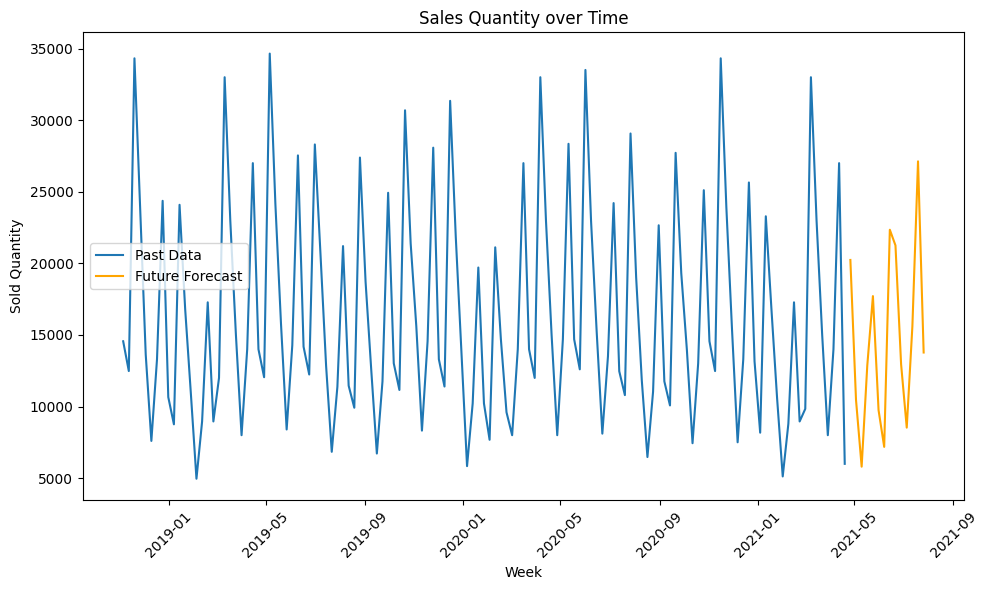

In [ ]:
import matplotlib.pyplot as plt

data.reset_index(inplace = True )
data['week'] = pd.to_datetime(data['week'])
df_forecast['week'] = pd.to_datetime(df_forecast['week'])

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 과거 데이터 그래프
plt.plot(data['week'], data['sold_quant'], label='Past Data')

# 미래 데이터 그래프 (주황색)
plt.plot(df_forecast['week'], df_forecast['sold_quant'], color='orange', label='Future Forecast')

plt.xlabel('Week')
plt.ylabel('Sold Quantity')
plt.title('Sales Quantity over Time')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
